# Decision tree regression

#### In scikit-learn
Regression is done with  `DecisionTreeRegressor`

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
def plot_decision_tree_regression(regr_1, regr_2):
    # Create a random dataset
    rng = np.random.RandomState(1)
    Xr = np.sort(5 * rng.rand(80, 1), axis=0)
    yr = np.sin(Xr).ravel()
    yr[::5] += 3 * (0.5 - rng.rand(16))

    # Fit regression model
    regr_1.fit(Xr, yr)
    regr_2.fit(Xr, yr)

    # Predict
    Xr_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_1 = regr_1.predict(Xr_test)
    y_2 = regr_2.predict(Xr_test)

    # Plot the results
    fig, ax = plt.subplots(1,3, figsize=(8,4))
    #plt.figure(figsize=(8,6))
    ax[0].scatter(Xr[:60], yr[:60], c="darkorange", label="train")
    ax[0].scatter(Xr[60:], yr[60:], c="red", label="test")
    ax[0].legend()
    ax[1].plot(Xr_test, y_1, color="darkorange", label="max_depth=2", linewidth=2)
    ax[1].plot(Xr_test[60:], y_1[60:], color="red", label="max_depth=2", linewidth=2)
    ax[2].plot(Xr_test, y_2, color="darkorange", label="max_depth=5", linewidth=2)
    ax[2].plot(Xr_test[60:], y_2[60:], color="red", label="max_depth=5", linewidth=2)
    ax[1].set_xlabel("data")
    ax[0].set_ylabel("target")
    ax[0].set_title("Data points")
    ax[1].set_title("Prediction Max depth = 2")
    ax[2].set_title("Prediction Max depth = 5")
    plt.tight_layout()
    plt.show()

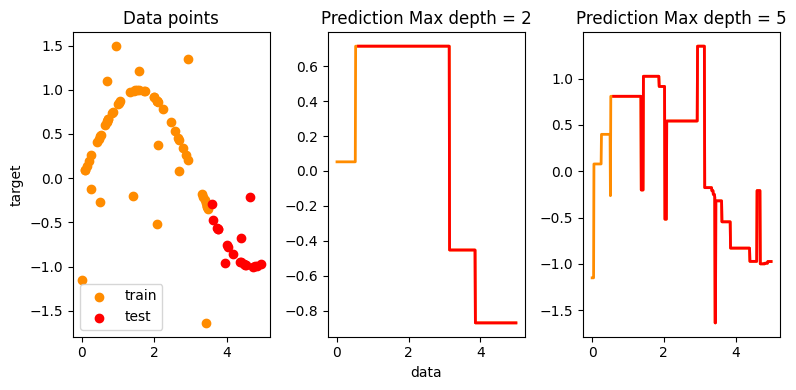

In [44]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

plot_decision_tree_regression(regr_1,regr_2)

***

### Decision trees do not extrapolate well

- The leafs return the same _mean_ value no matter how far the new data point lies from the training examples.
- Example on the `ram_price` forecasting dataset

In [62]:
url = 'https://github.com/amueller/introduction_to_ml_with_python/blob/main/data/ram_price.csv?raw=true'
ram_prices = pd.read_csv(url, index_col=0)

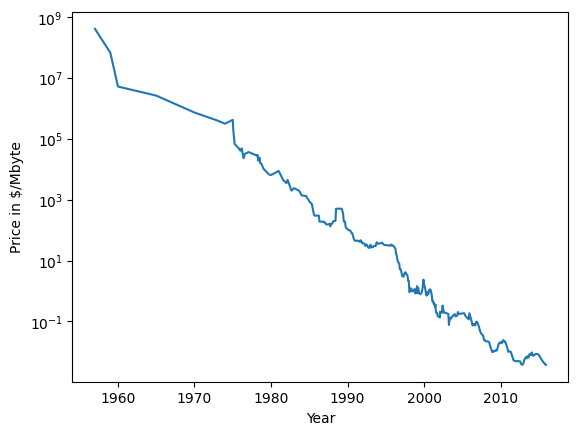

In [63]:
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

In [78]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
Xl_train = data_train.date.to_numpy().reshape(-1, 1)
# we use a log-transform to get a simpler relationship of data to target
yl_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(Xl_train, yl_train)
linear_reg = LinearRegression().fit(Xl_train, yl_train)

# predict on all data
X_all = ram_prices.date.to_numpy().reshape(-1, 1)#[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

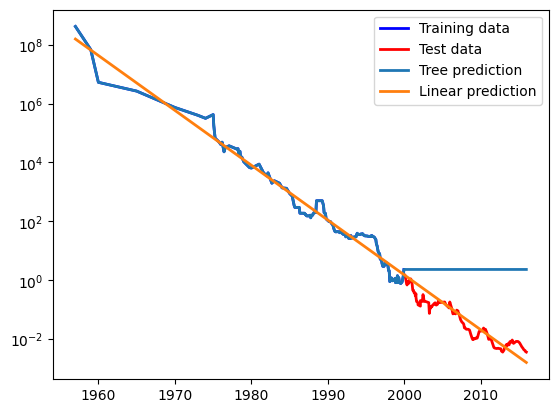

In [83]:
plt.semilogy(data_train.date, data_train.price,c='b', label="Training data")
plt.semilogy(data_test.date, data_test.price,c='r', label="Test data")
plt.semilogy(ram_prices.date, price_tree, linestyle='-', label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, linestyle='-', label="Linear prediction")
plt.legend();

***

## Tree based regression

Scikit learn's default decision tree regressor uses mean-value regression

<img src = "https://github.com/ankonzoid/LearningX/raw/master/advanced_ML/model_tree/images/coverart_mean_regr_fit.png" width=700>

**Tree model**
* Instead of predicting a single value per leaf (e.g. mean value for regression), you can build a model on all the points remaining in a leaf
    * E.g. a linear regression model
* Can learn more complex concepts, extrapolates better. Overfits easily.
    

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/04_model_trees.png" alt="ml" style="float: left; width: 60%;"/>

<img src="https://github.com/ankonzoid/LearningX/raw/master/advanced_ML/model_tree/images/coverart_linear_regr_fit.png" width=700>

***

## A note on under- and overfitting

Broadly speaking
* Deep trees have high variance but low bias
* Shallow trees have high bias but very low variance


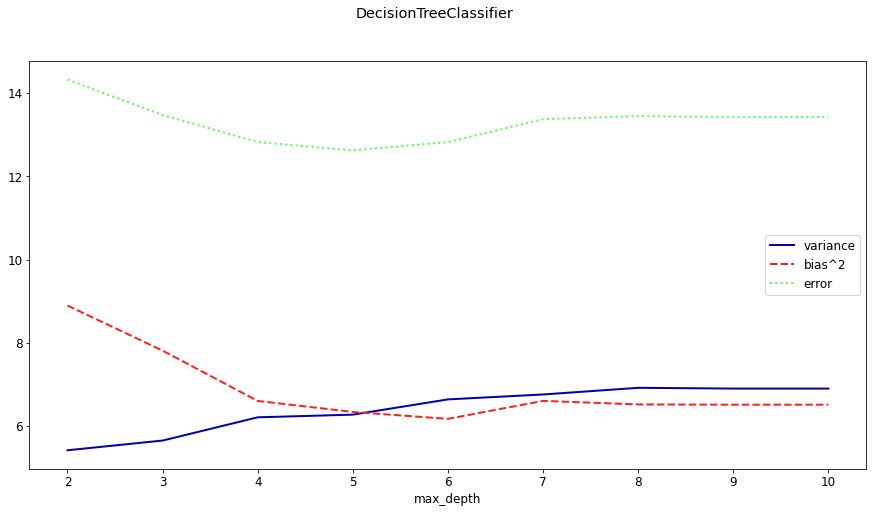

In [ ]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Bias-Variance Computation
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

def plot_bias_variance(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    max_depth= range(2,11)

    for i in max_depth:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,max_depth=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(10*fig_scale,5*fig_scale))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(max_depth, var_scores,label ="variance" )
    plt.plot(max_depth, np.square(bias_scores),label ="bias^2")
    plt.plot(max_depth, err_scores,label ="error" )
    plt.xlabel("max_depth")
    plt.legend(loc="best")
    plt.show()

cancer = load_breast_cancer()
Xc, yc = cancer.data, cancer.target
dt = DecisionTreeClassifier()
plot_bias_variance(dt, Xc, yc)